In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# pip install pmdarima

In [15]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [16]:
# Load historical weather data
historical_weather = pd.read_csv('/content/drive/MyDrive/DS_dataset/historical_weather.csv')
#Parse strings to datetime type
historical_weather = historical_weather[['city_id', 'date', 'avg_temp_c']]
historical_weather['date'] = pd.to_datetime(historical_weather['date']) #convert from string to datetime
# indexed_historical_weather = historical_weather.set_index(['date', 'avg_temp_c'])
# indexed_historical_weather

WARNING - (py.warnings._showwarnmsg) - <ipython-input-17-9ddb2a586a73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data.drop('city_id', axis=1, inplace=True)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data.drop('city_id', axis=1, inplace=True)



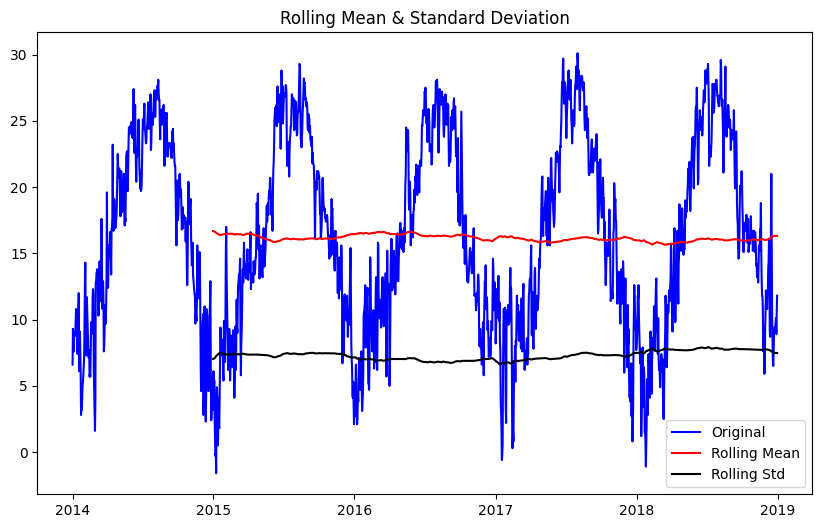

Results of Dickey Fuller Test:
Test Statistic                   -2.435106
p-value                           0.132072
#Lags Used                       12.000000
Number of Observations Used    1813.000000
Critical Value (1%)              -3.433962
Critical Value (5%)              -2.863136
Critical Value (10%)             -2.567619
dtype: float64


In [17]:
city_data = historical_weather[historical_weather['city_id'] == 'C001']
city_data.drop('city_id', axis=1, inplace=True)
indexed_city_data = city_data.set_index(['date'])

indexed_city_data.fillna(method='ffill', inplace=True)

def test_stationarity(timeseries, target):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=365).mean()
    movingSTD = timeseries.rolling(window=365).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries[target], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(indexed_city_data, 'avg_temp_c')

resid
date                
2014-01-04 -0.388438
2014-01-05  0.003815
2014-01-06  0.181013
2014-01-07 -0.468987
2014-01-08 -0.715086
...              ...
2018-12-24  0.452441
2018-12-25 -0.354702
2018-12-26 -0.029372
2018-12-27  0.203210
2018-12-28  0.398760

[1820 rows x 1 columns]

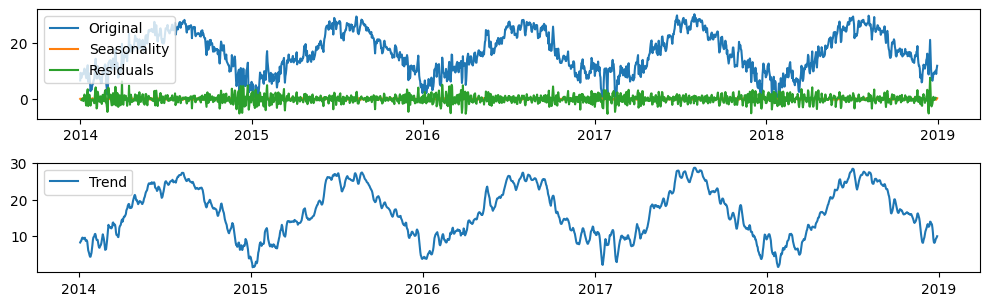

In [18]:
decomposition = seasonal_decompose(indexed_city_data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexed_city_data, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)

decomposedLogData = decomposedLogData.to_frame()
decomposedLogData

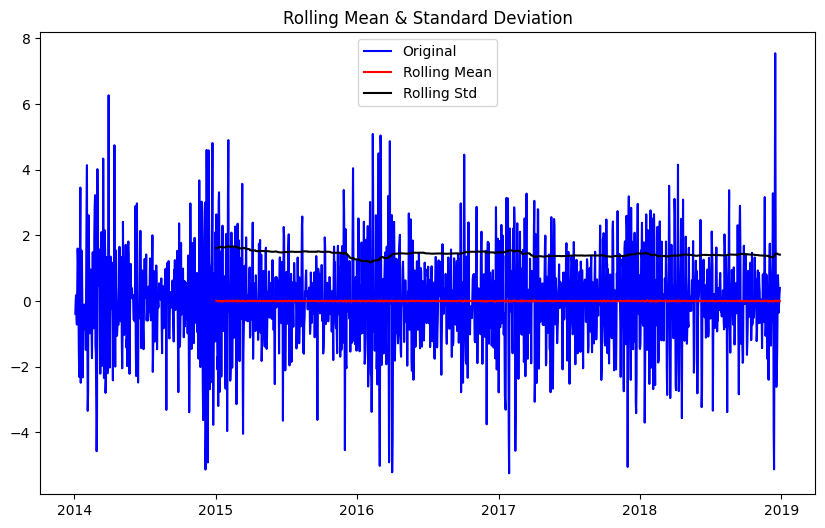

Results of Dickey Fuller Test:
Test Statistic                -1.509342e+01
p-value                        8.131758e-28
#Lags Used                     2.500000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


In [19]:
test_stationarity(decomposedLogData, 'resid')

In [20]:
# # Fit auto ARIMA model to find optimal p, d, q
# auto_model = pm.auto_arima(indexed_city_data['avg_temp_c'], seasonal=True, m=12,
#                            stepwise=True, trace=True)

# # Print the optimal order
# auto_model.summary()

In [21]:
def train_arima_and_predict(city_data, steps):
    # Fit ARIMA model
    model = SARIMAX(city_data['avg_temp_c'], order=(3, 0, 1), seasonal_order=(0, 0, 0, 12))
    model_fit = model.fit(disp=False)

    # Forecast
    forecast = model_fit.forecast(steps=steps)
    return forecast

In [22]:
# pip install neuralprophet

In [23]:
import warnings
from neuralprophet import NeuralProphet

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def train_neuralprophet_and_predict(city_data, steps):
    # Reset index to convert index back to a column
    city_data = city_data.reset_index()

    # Prepare data
    city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'}, inplace=True)

    # Initialize the model with daily seasonality enabled
    model = NeuralProphet(daily_seasonality=True)

    # Fit the model
    model.fit(city_data, freq='D')

    # Create future dataframe
    future = model.make_future_dataframe(city_data, periods=steps)

    # Make predictions
    forecast = model.predict(future)

    return forecast[['ds', 'yhat1']]


In [24]:
indexed_city_data

avg_temp_c
date                  
2014-01-01         6.6
2014-01-02         9.3
2014-01-03         7.6
2014-01-04         7.6
2014-01-05         8.6
...                ...
2018-12-27         9.7
2018-12-28        10.1
2018-12-29         8.9
2018-12-30        10.7
2018-12-31        11.8

[1826 rows x 1 columns]

In [25]:
forecast = train_arima_and_predict(indexed_city_data, 7)
forecast

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


ds     yhat1
0 2019-01-01  7.961256
1 2019-01-02  7.844655
2 2019-01-03  7.770313
3 2019-01-04  7.254342
4 2019-01-05  7.384991
5 2019-01-06  7.692350
6 2019-01-07  7.831468

# Do forcasting for all cities

In [26]:
# Load the submission key
submission_key = pd.read_csv('/content/drive/MyDrive/DS_dataset/submission_key.csv')

# Create a dictionary to store the forecasts
forecasts = {}

# Predict for each city
for city_id in historical_weather['city_id'].unique():
    city_data = historical_weather[historical_weather['city_id'] == city_id].copy()
    city_data.drop('city_id', axis=1, inplace=True)
    indexed_city_data = city_data.set_index('date').asfreq('D')

    # Make predictions for 7 days
    forecast = train_arima_and_predict(indexed_city_data, steps=7)

    # Store the forecast in the dictionary
    forecast_dict = forecast.set_index('ds')['yhat1'].to_dict()
    forecasts[city_id] = forecast_dict



WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 23 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 23 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 3 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 19 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 19 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 3 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 2 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 2 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 15 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 15 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 3 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 25 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 25 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 13 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 13 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 3 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 14 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 2 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 2 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 37 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 37 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (56) is too small than the required number                     for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 3 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 4 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 9 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 9 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 2 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 2 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 70 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 70 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (55) is too small than the required number                     for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 14 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 14 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 2 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 2 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 16 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 16 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 37 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 37 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (56) is too small than the required number                     for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 6 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 6 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1101 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1101 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling year

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (23) is too small than the required number                     for the learning rate finder (222). The results might not be optimal.


Finding best initial lr:   0%|          | 0/222 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 3 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 3 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 6 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 6 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 2 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 2 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
INFO:NP.config:Auto-set epochs to 90


Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 1 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (58) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 7 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 7 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (232). The results might not be optimal.


Finding best initial lr:   0%|          | 0/232 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 4 rows with NaNs in 'y' column.
INFO:NP.data.processing:Dropped 4 rows with NaNs in 'y' column.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size t

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (57) is too small than the required number                     for the learning rate finder (231). The results might not be optimal.


Finding best initial lr:   0%|          | 0/231 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.945% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [27]:
forecasts

{'C001': {Timestamp('2019-01-01 00:00:00'): 7.894534587860107,
  Timestamp('2019-01-02 00:00:00'): 7.835322856903076,
  Timestamp('2019-01-03 00:00:00'): 7.698001384735107,
  Timestamp('2019-01-04 00:00:00'): 7.164036273956299,
  Timestamp('2019-01-05 00:00:00'): 7.335276126861572,
  Timestamp('2019-01-06 00:00:00'): 7.5834479331970215,
  Timestamp('2019-01-07 00:00:00'): 7.795854091644287},
 'C002': {Timestamp('2019-01-01 00:00:00'): 14.921122550964355,
  Timestamp('2019-01-02 00:00:00'): 15.00546646118164,
  Timestamp('2019-01-03 00:00:00'): 14.895739555358887,
  Timestamp('2019-01-04 00:00:00'): 14.827117919921875,
  Timestamp('2019-01-05 00:00:00'): 14.777254104614258,
  Timestamp('2019-01-06 00:00:00'): 14.680086135864258,
  Timestamp('2019-01-07 00:00:00'): 14.65276050567627},
 'C003': {Timestamp('2019-01-01 00:00:00'): 26.129850387573242,
  Timestamp('2019-01-02 00:00:00'): 26.2386417388916,
  Timestamp('2019-01-03 00:00:00'): 26.226472854614258,
  Timestamp('2019-01-04 00:00:00

In [28]:
# Prepare the submission dataframe
submission = pd.read_csv('/content/drive/MyDrive/DS_dataset/sample_submission.csv')

# Fill in the predictions
for i, row in submission_key.iterrows():
    city_id = row['city_id']
    date = row['date']
    submission.loc[submission['submission_ID'] == row['submission_ID'], 'avg_temp_c'] = forecasts[city_id][pd.to_datetime(date).day - 1]

# Save the submission file
submission.to_csv('submission.csv', index=False)

Date 2019-01-01 not found in forecasts for city C001. Error: '2019-01-01'
Date 2019-01-02 not found in forecasts for city C001. Error: '2019-01-02'
Date 2019-01-03 not found in forecasts for city C001. Error: '2019-01-03'
Date 2019-01-04 not found in forecasts for city C001. Error: '2019-01-04'
Date 2019-01-05 not found in forecasts for city C001. Error: '2019-01-05'
Date 2019-01-06 not found in forecasts for city C001. Error: '2019-01-06'
Date 2019-01-07 not found in forecasts for city C001. Error: '2019-01-07'
Date 2019-01-01 not found in forecasts for city C002. Error: '2019-01-01'
Date 2019-01-02 not found in forecasts for city C002. Error: '2019-01-02'
Date 2019-01-03 not found in forecasts for city C002. Error: '2019-01-03'
Date 2019-01-04 not found in forecasts for city C002. Error: '2019-01-04'
Date 2019-01-05 not found in forecasts for city C002. Error: '2019-01-05'
Date 2019-01-06 not found in forecasts for city C002. Error: '2019-01-06'
Date 2019-01-07 not found in forecasts